In [53]:
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from datetime import datetime
import distutils.dir_util
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
import numpy as np

from keras.layers import Dense, Input, Lambda, BatchNormalization, Conv2D, Dropout
from keras.layers import ZeroPadding2D, MaxPooling2D, AveragePooling2D, Activation, Flatten
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from spatial_transformer import SpatialTransformer

from keras import __version__
print(__version__)

2.0.3


In [54]:
RESULTS_DIR = '/home/ubuntu/data/fishing/results'

import bcolz
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="VGG16_640_conv_feats/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels

trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("VGG16_640_conv_feats/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("VGG16_640_conv_feats/val_")
test_filenames, test_conv_features, test_labels = load_precomputed_data("VGG16_640_conv_feats/test_")

In [55]:
len(trn_filenames), trn_conv_features.shape, len(trn_labels)

(3276, (3276, 11, 20, 512), 3276)

In [56]:
#classifier_input_shape = resnet_base.layers[-1].output_shape[1:] 
# i.e. shape of conv features (produces (None, None, None, 2048))
classifier_input_shape = (11, 20, 512)
# classifier_input_shape = resnet_base.layers[-1].output_shape[1:]
classifier_input = Input(shape=classifier_input_shape)

In [57]:
# Create classifier model

x = Flatten()(classifier_input)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v1 = Model(classifier_input, x)

#from keras.optimizers import SGD
classifier_model_v1.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
classifier_model_v1.fit(trn_conv_features, trn_labels,
                                          batch_size=32, 
                                          epochs=5,
                                          validation_data=(val_conv_features, val_labels),
                                          shuffle=True)

Train on 3276 samples, validate on 500 samples
Epoch 1/5
3276/3276 [==============================] - 2s - loss: 0.8718 - acc: 0.7317 - val_loss: 0.4194 - val_acc: 0.9100
Epoch 2/5
3276/3276 [==============================] - 1s - loss: 0.2609 - acc: 0.9429 - val_loss: 0.2734 - val_acc: 0.9260
Epoch 3/5
3276/3276 [==============================] - 1s - loss: 0.1465 - acc: 0.9719 - val_loss: 0.2115 - val_acc: 0.9500
Epoch 4/5
3276/3276 [==============================] - 1s - loss: 0.0904 - acc: 0.9878 - val_loss: 0.1807 - val_acc: 0.9500
Epoch 5/5
3276/3276 [==============================] - 1s - loss: 0.0624 - acc: 0.9939 - val_loss: 0.1682 - val_acc: 0.9580


In [61]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [62]:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=classifier_input_shape))
locnet.add(Conv2D(20, (3, 3)))
# locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Conv2D(20, (3, 3)))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))



In [63]:
nb_classes = 8

model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,
                             output_size=(30,30), input_shape=classifier_input_shape))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [70]:
model.fit(trn_conv_features, trn_labels, 
                                          batch_size=32, 
                                          epochs=2,
                                          validation_data=(val_conv_features,val_labels),
                                          shuffle=True)

# run lots of times

Train on 3276 samples, validate on 500 samples
Epoch 1/2
3276/3276 [==============================] - 6s - loss: 0.0606 - acc: 0.9799 - val_loss: 0.5035 - val_acc: 0.8760
Epoch 2/2
3276/3276 [==============================] - 6s - loss: 0.1335 - acc: 0.9582 - val_loss: 0.3815 - val_acc: 0.9000


In [36]:
nb_classes = 8

no_spatial_model = Sequential()
# locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=classifier_input_shape))

# no_spatial_model.add(SpatialTransformer(localization_net=locnet,
#                              output_size=(30,30), input_shape=classifier_input_shape))

no_spatial_model.add(Conv2D(32, (3, 3), padding='same', input_shape=classifier_input_shape))
no_spatial_model.add(Activation('relu'))
no_spatial_model.add(MaxPooling2D(pool_size=(2, 2)))
no_spatial_model.add(Conv2D(32, (3, 3)))
no_spatial_model.add(Activation('relu'))
no_spatial_model.add(MaxPooling2D(pool_size=(2, 2)))

no_spatial_model.add(Flatten())
no_spatial_model.add(Dense(256))
no_spatial_model.add(Activation('relu'))

no_spatial_model.add(Dense(nb_classes))
no_spatial_model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam')
no_spatial_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
no_spatial_model.fit(trn_conv_features, trn_labels, 
                                          batch_size=32, 
                                          epochs=2,
                                          validation_data=(val_conv_features,val_labels),
                                          shuffle=True)

Train on 3276 samples, validate on 500 samples
Epoch 1/20
3276/3276 [==============================] - 2s - loss: 0.2043 - acc: 0.9447 - val_loss: 0.2840 - val_acc: 0.9180
Epoch 2/20
3276/3276 [==============================] - 2s - loss: 0.0999 - acc: 0.9753 - val_loss: 0.2376 - val_acc: 0.9460
Epoch 3/20
3276/3276 [==============================] - 2s - loss: 0.0465 - acc: 0.9905 - val_loss: 0.2352 - val_acc: 0.9480
Epoch 4/20
3276/3276 [==============================] - 2s - loss: 0.0240 - acc: 0.9966 - val_loss: 0.1862 - val_acc: 0.9580
Epoch 5/20
3276/3276 [==============================] - 2s - loss: 0.0132 - acc: 0.9973 - val_loss: 0.2502 - val_acc: 0.9480
Epoch 6/20
3276/3276 [==============================] - 2s - loss: 0.0041 - acc: 1.0000 - val_loss: 0.2103 - val_acc: 0.9580
Epoch 7/20
3276/3276 [==============================] - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.2342 - val_acc: 0.9560
Epoch 8/20
3276/3276 [==============================] - 2s - loss: 0.0013 - ac

In [73]:
XX = model.input
YY = model.layers[0].output
F = K.function([XX], [YY])

In [111]:
image_num=0
inp = np.expand_dims(val_conv_features[image_num],0)
Xresult = F([inp.astype('float32')])[0][0,:,:,:]

In [112]:
Xresult.shape # not quite sure of the dimensions to plot here as it is (1,30,30,512) in the example the 512 is 1


(30, 30, 512)

In [106]:
import scipy
from matplotlib import pyplot as plt

cm = scipy.misc.imresize(Xresult, (360,640), interp='nearest')

In [107]:
import matplotlib.image as mpimg

img_path = '/home/ubuntu/data/fishing/valid/'+ val_filenames[image_num]
img=mpimg.imread(img_path)


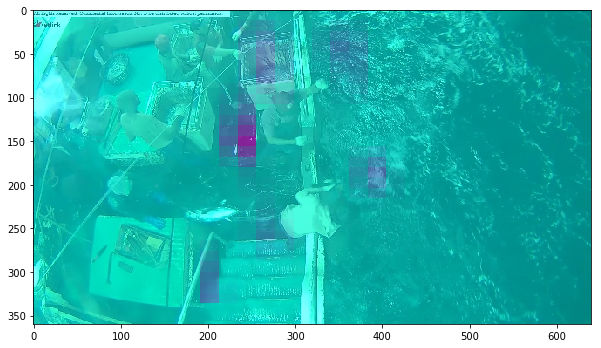

In [108]:
plt.figure(figsize=(10,10))
plt.imshow(scipy.misc.imresize(img, (360,640), interp='nearest'))
plt.imshow(cm, cmap="cool", alpha=0.5)

plt.show()